<a href="https://colab.research.google.com/github/hereagain-Y/test-only/blob/main/One_hot_VAE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Try One-hot encoding in VAE model 

In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torchvision.transforms as transforms
import numpy as np
from tqdm import tqdm
from torchvision.utils import save_image, make_grid
from torch.utils.data import DataLoader, Subset
from sklearn.model_selection import train_test_split

In [5]:
code = ['G','A','L','M','F','W','K','Q','E','S','P','V','I','C','Y','H','R','N','D','T']
index_code = {}
code_index = {}
l_max = 20
for i in range(len(code)):
    index_code[i] = code[i]
    code_index[ code[i] ] = i

def oneHotEncode(seq, l_max=l_max, index_code=index_code, code_index=code_index):
    n_amino = 20
    matrix = np.zeros((l_max,n_amino)).astype(int)
    for i in range(len(seq)):
        matrix[ i , code_index[seq[i]] ] = 1
    return matrix

def oneHotDecode(matrix, l_max=l_max, index_code=index_code, code_index=code_index):
    seq_decode = ''
    for i in range(l_max):
        row = matrix[i,]
        if np.sum(row) == 0:
            break
        seq_decode += index_code[ np.where( row==1 )[0][0] ]
    return seq_decode

cuda = False
DEVICE = torch.device("cuda" if cuda else "cpu")
batch_size = 1000
x_dim=400 # 20*20
hidden_dim = 256
hidden_dim2 = 128
hidden_dim3 = 64
latent_dim = 32

lr = 1e-3
epochs = 1000
#exec(open("/dcl02/hongkai/data/shuai/VAE/tmp.py").read())


In [6]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [7]:

data_train = pd.read_csv(r'/content/drive/My Drive/DL/VAE/NormalCDR3.txt',delimiter='\t',header=None,names=['seq'])
#only take seqs length <= 20
data_train['length'] = [len(seq) for seq in data_train['seq']]
data_train = data_train[ data_train['length']<=20 ]
seq_train = list( data_train['seq'] )

seq_train_matrix = []
for seq in seq_train:
    seq_train_matrix.append( oneHotEncode(seq) )

seq_train_matrix = np.array( seq_train_matrix )

In [8]:

r1_transform=torch.from_numpy(seq_train_matrix)
r1_transform=r1_transform.float()
train_ds, test_ds = torch.utils.data.random_split(r1_transform, (int(0.8*len(r1_transform)), len(r1_transform)-int(0.8*len(r1_transform))))
print(train_ds, test_ds)
train_loader = DataLoader(dataset=train_ds, batch_size=1000)
test_loader  = DataLoader(dataset=test_ds,  batch_size=1000)

<torch.utils.data.dataset.Subset object at 0x7f17f145c650> <torch.utils.data.dataset.Subset object at 0x7f17f145ccd0>


In [23]:
class Encoder(nn.Module):    
    def __init__(self, input_dim, hidden_dim,hidden_dim2,hidden_dim3,latent_dim):
        super(Encoder, self).__init__()

        self.FC_input = nn.Linear(input_dim, hidden_dim)
        self.FC_input2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_input3 = nn.Linear(hidden_dim, hidden_dim2)
        self.FC_input4 = nn.Linear(hidden_dim2, hidden_dim3)
        self.FC_mean  = nn.Linear(hidden_dim3, latent_dim)
        self.FC_var  = nn.Linear(hidden_dim3, latent_dim)
        #i change it from LeakReLU 0.2 to ReLU
        self.ReLU = nn.ReLU(0)       
        self.training = True
        
    def forward(self, x):
        h_       = self.ReLU(self.FC_input(x))
        h_       = self.ReLU(self.FC_input2(h_))
        h_       = self.ReLU(self.FC_input3(h_))
        h_       = self.ReLU(self.FC_input4(h_))
    
        mean     = self.FC_mean(h_)  
        log_var  = self.FC_var(h_) 
        return mean, log_var
    
class Decoder(nn.Module):
    def __init__(self, latent_dim, hidden_dim,hidden_dim2,hidden_dim3,output_dim):
        super(Decoder, self).__init__()
        self.FC_hidden = nn.Linear(latent_dim, hidden_dim3)
        self.FC_hidden4 = nn.Linear(hidden_dim3, hidden_dim2)
        self.FC_hidden3 = nn.Linear(hidden_dim2, hidden_dim)
        self.FC_hidden2 = nn.Linear(hidden_dim, hidden_dim)
        self.FC_output = nn.Linear(hidden_dim, output_dim)      
        #i change it from LeakReLU 0.2 to ReLU
        self.ReLU = nn.ReLU(0)   
        
    def forward(self, x):
        h     = self.ReLU(self.FC_hidden(x))
        h     = self.ReLU(self.FC_hidden4(h))
        h     = self.ReLU(self.FC_hidden3(h))
        h     = self.ReLU(self.FC_hidden2(h))     
        x_hat = self.ReLU(self.FC_output(h))
        return x_hat

class Model(nn.Module):
    def __init__(self, Encoder, Decoder):
        super(Model, self).__init__()
        self.Encoder = Encoder
        self.Decoder = Decoder
        
    def reparameterization(self, mean,var):  
        epsilon = torch.randn_like(var).to(DEVICE) 
        z = mean + var*epsilon
        return z
                       
    def forward(self, x):
        mean, log_var = self.Encoder(x)
        z = self.reparameterization(mean, torch.exp(0.5 * log_var)) # takes exponential function (log var -> var) ]
        x_hat            = self.Decoder(z)
        
        return x_hat, mean, log_var

encoder = Encoder(input_dim=x_dim, hidden_dim=hidden_dim, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3,latent_dim=latent_dim)
decoder = Decoder(latent_dim=latent_dim, hidden_dim = hidden_dim, hidden_dim2=hidden_dim2, hidden_dim3=hidden_dim3,output_dim = x_dim)

model = Model(Encoder=encoder, Decoder=decoder).to(DEVICE)

In [24]:
print(model)

Model(
  (Encoder): Encoder(
    (FC_input): Linear(in_features=400, out_features=256, bias=True)
    (FC_input2): Linear(in_features=256, out_features=256, bias=True)
    (FC_input3): Linear(in_features=256, out_features=128, bias=True)
    (FC_input4): Linear(in_features=128, out_features=64, bias=True)
    (FC_mean): Linear(in_features=64, out_features=32, bias=True)
    (FC_var): Linear(in_features=64, out_features=32, bias=True)
    (ReLU): ReLU()
  )
  (Decoder): Decoder(
    (FC_hidden): Linear(in_features=32, out_features=64, bias=True)
    (FC_hidden4): Linear(in_features=64, out_features=128, bias=True)
    (FC_hidden3): Linear(in_features=128, out_features=256, bias=True)
    (FC_hidden2): Linear(in_features=256, out_features=256, bias=True)
    (FC_output): Linear(in_features=256, out_features=400, bias=True)
    (ReLU): ReLU()
  )
)


In [25]:

from torch.optim import Adam
#BCE_loss = nn.BCELoss()
def loss_function(x, x_hat, mean, log_var):
    MSELoss_criterion = nn.MSELoss()
    reproduction_loss = MSELoss_criterion(x_hat, x) 
    KLD      = - 0.5 * torch.sum(1+ log_var - mean.pow(2) - log_var.exp())
    return reproduction_loss + KLD


optimizer = Adam(model.parameters(), lr=lr)

In [11]:
print("start training VAE")

start training VAE


In [27]:
model.train()
train_loss= []
testtoal_loss= []
for epoch in range(epochs):
    overall_loss = 0
    overall_testloss= 0
    for batch_idx, x in enumerate(train_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)
        #zero grad
        optimizer.zero_grad()
        #----
        x_hat, mean, log_var = model(x)
        loss = loss_function(x, x_hat, mean,log_var)
        overall_loss += loss.item()  
        #back prog
        loss.backward()     
        optimizer.step()
    #test loss, but not used for train
    for batch_idx, x in enumerate(test_loader):
        x = x.view(len(x), x_dim)
        x = x.to(DEVICE)
        pred, mean, log_var = model(x)
        test_loss = loss_function(x, pred, mean,log_var)
        overall_testloss += test_loss.item()   
    if (epoch % 100 == 0):
      #print('====> Epoch %d done! Average Loss:  = %.2e, Average test loss = %.2e' % (epoch,overall_loss / (batch_idx*batch_size),overall_testloss/(batch_idx*batch_size)))
        
        
      print("\tEpoch", epoch , "complete!", "\tAverage Loss: ", overall_loss / len(train_ds),#overall_loss / (batch_idx*batch_size),
        "\tAverage Test Loss: " , overall_testloss/len(test_ds))
    with open('/content/drive/My Drive/DL/VAE/record.txt','w') as f:
      f.writelines(str(epoch))
    train_loss.append( overall_loss / len(train_ds) )
    testtoal_loss.append( overall_testloss / len(test_ds) )
    
print("Finish!!")    

	Epoch 0 complete! 	Average Loss:  2.6515108766034244e-05 	Average Test Loss:  2.656882372684777e-05
	Epoch 100 complete! 	Average Loss:  2.5594436505343765e-05 	Average Test Loss:  2.4601080222055317e-05
	Epoch 200 complete! 	Average Loss:  2.4475016281940042e-05 	Average Test Loss:  2.4399724788963796e-05
	Epoch 300 complete! 	Average Loss:  2.4668698431923985e-05 	Average Test Loss:  2.4406830547377468e-05
	Epoch 400 complete! 	Average Loss:  2.44622906902805e-05 	Average Test Loss:  2.4395933840423822e-05
	Epoch 500 complete! 	Average Loss:  2.4857576529029757e-05 	Average Test Loss:  2.4392559425905346e-05
	Epoch 600 complete! 	Average Loss:  2.4432056874502452e-05 	Average Test Loss:  2.437607222236693e-05
	Epoch 700 complete! 	Average Loss:  2.442741469712928e-05 	Average Test Loss:  2.437229920178652e-05
	Epoch 800 complete! 	Average Loss:  2.442710631294176e-05 	Average Test Loss:  2.437049150466919e-05
	Epoch 900 complete! 	Average Loss:  2.4433060083538295e-05 	Average Test 

In [34]:
# save model 
torch.save(model, '/content/drive/My Drive/DL/VAE/Onehot_modified_1000_echo_cat_train.apx')

In [31]:
import matplotlib.pyplot as plt

In [32]:
def plotCurve(x_vals,y_vals,x_label, y_label,
              x2_vals=None, y2_vals=None, legend=None,figsize=(3.5,2.5)):
    plt.xlabel(x_label)
    plt.ylabel(y_label)
    plt.semilogy(x_vals, y_vals)
    if x2_vals and y2_vals:
        plt.semilogy(x2_vals, y2_vals, linestyle=':')
    
    if legend:
        plt.legend(legend)
    plt.savefig('/content/drive/My Drive/DL/VAE/train.png')

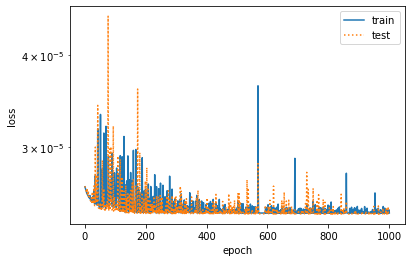

In [33]:
plotCurve(range(1,epochs+1),train_loss,"epoch","loss",
          range(1,epochs+1),testtoal_loss,
          ['train','test'])